<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/XGBOOST_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Setup

# Install required packages (uncomment if not already installed)
!pip install -q yfinance xgboost scikit-learn matplotlib pandas numpy statsmodels shap

# Imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from xgboost import XGBClassifier, XGBRegressor

# Setup
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# HELPERS

This section of the code creates helper functions that make it easier to evaluate models, plot data, and add financial indicators. It first defines error metrics like RMSE, MAPE, SMAPE, MAE, and R², which measure how accurate predictions are compared to actual values. Then it includes a plotting function to quickly draw time series graphs of stock data or predictions. Another helper function adds a numeric time index to dates so that time can be used in models. Finally, it defines functions for popular trading indicators such as RSI (which shows if a stock is overbought or oversold) and MACD (which tracks short-term and long-term momentum). Together, these helpers provide tools for measuring performance, visualising results, and enriching the dataset with useful financial signals.

In [ ]:
# 2) Helpers

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# --- Error Metrics ---
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

def metrics_dict(y_true, y_pred) -> Dict[str, float]:
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE%": mape(y_true, y_pred),
        "sMAPE%": smape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# --- Plot Helpers ---
def plot_series(df, date_col, value_col, title="Series"):
    plt.figure(figsize=(12, 4))
    plt.plot(df[date_col], df[value_col])
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.tight_layout()
    plt.show()

def add_time_idx(df, date_col="Date"):
    df = df.copy()
    df["t"] = (pd.to_datetime(df[date_col]) - pd.to_datetime(df[date_col]).min()).dt.days
    return df

# --- Technical Indicators ---
def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up / (ma_down + 1e-12)
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist


# Load Data

This section of the code is responsible for loading stock price data. It first checks if there are any local CSV files available (like stationary_dataset.csv or GFI_dataset.csv) and loads one if found. If no local file exists, it automatically downloads data from Yahoo Finance for the stock ticker “GFI” starting from 2012. Once the data is loaded, it detects which column represents the date and which column represents the closing price, then renames and standardises them to “Date” and “Close.” The data is cleaned by removing missing values, sorted by date, and reset with a clean index. Finally, the closing price is plotted as a time series chart, and the first few rows of the dataset are displayed as a preview. This ensures that the dataset is always available, either from local storage or directly from Yahoo Finance.

📡 Fetching GFI from Yahoo Finance...


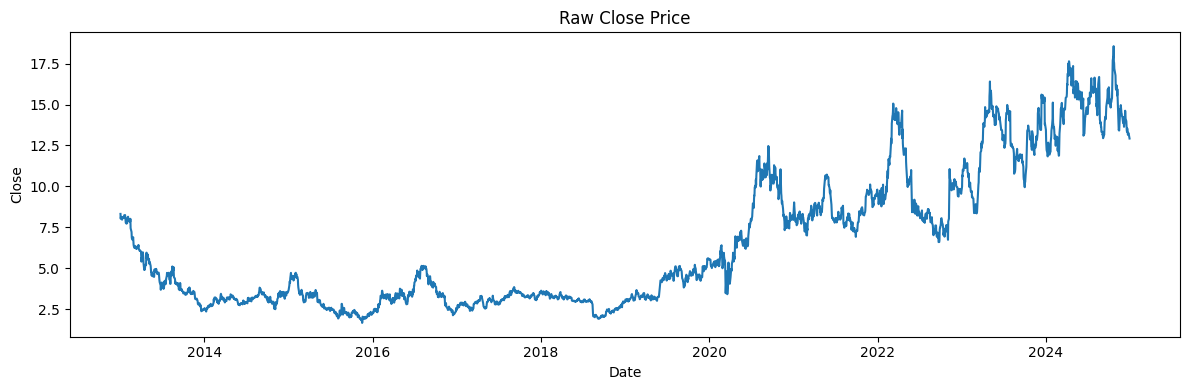

Price,Date,Close
Ticker,,GFI
0,2013-01-02,8.313621
1,2013-01-03,8.020277
2,2013-01-04,8.140279
3,2013-01-07,8.026941
4,2013-01-08,8.000277


In [ ]:
# 3) Data Loading

import pandas as pd
import yfinance as yf

# Fetch data directly from Yahoo Finance (2013–2024)
TICKER, START, END = "GFI", "2013-01-01", "2024-12-31"
print(f"📡 Fetching {TICKER} from Yahoo Finance...")

df = yf.download(TICKER, start=START, end=END, progress=False).reset_index()[["Date", "Close"]]

# Final cleaning
df = df.dropna().reset_index(drop=True)

# Plot
plot_series(df, "Date", "Close", "Raw Close Price")

# Preview
df.head()


# Feature engineerinng

This block of code prepares features from the stock price data so they can be used in machine learning models. It starts by creating basic features like daily returns and lagged closing prices (1-day, 5-day, 10-day shifts). Then it adds rolling window statistics (moving averages and standard deviations over different periods) and technical indicators such as RSI and MACD. It also creates date-based features like year, month, and day, along with a numeric time index. The target variable is set as the next day’s closing price, meaning the model will try to predict tomorrow’s price. After that, missing values are removed, only numeric columns are kept, and any invalid rows (like infinities or NaNs) are filtered out. Finally, the cleaned dataset is split into a feature matrix X and a target vector y, with a check to confirm everything is numeric and ready for modelling.

In [ ]:
# 4) Feature Engineering

import pandas as pd
import numpy as np

work = df.copy()

# --- Basic Features ---
work["Return"] = np.log(work["Close"]).diff()
work["Lag1"] = work["Close"].shift(1)
work["Lag5"] = work["Close"].shift(5)
work["Lag10"] = work["Close"].shift(10)

# Rolling window features
for w in [5, 10, 20, 60]:
    work[f"RollMean_{w}"] = work["Close"].rolling(w).mean()
    work[f"RollStd_{w}"] = work["Close"].rolling(w).std()

# Technical indicators
work["RSI_14"] = rsi(work["Close"], 14)
macd_line, sig, hist = macd(work["Close"], 12, 26, 9)
work["MACD"], work["MACDsig"], work["MACDh"] = macd_line, sig, hist

# Date-based features
work["Year"] = work["Date"].dt.year
work["Month"] = work["Date"].dt.month
work["Day"] = work["Date"].dt.day
work = add_time_idx(work, "Date")

# Target: next-day close
work["y"] = work["Close"].shift(-1)

# --- Drop NaNs (from lags/rolls/target) ---
work = work.dropna().reset_index(drop=True)

# --- Strict Numeric Features Only ---
candidates = work.drop(columns=["Date", "y"], errors="ignore")
numeric_only = candidates.select_dtypes(include=[np.number]).copy()
non_numeric = sorted(set(candidates.columns) - set(numeric_only.columns))

if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)

# --- Ensure valid numeric data ---
X = numeric_only.apply(pd.to_numeric, errors="coerce").astype("float64")
y = pd.to_numeric(work["y"], errors="coerce").astype("float64").values

# Filter valid rows
valid = np.isfinite(X).all(axis=1) & np.isfinite(y)
if valid.sum() < len(y):
    print(f"Filtered out {len(y) - valid.sum()} rows with non-finite values in features/target.")

# Keep only valid rows
work = work.loc[valid].reset_index(drop=True)
X = X.loc[valid].reset_index(drop=True)
y = y[valid]
feat_cols = X.columns.tolist()

# --- Final Sanity Check ---
assert all(pd.api.types.is_numeric_dtype(X[c]) for c in X.columns), "Non-numeric features remain."
print(f"✅ Feature matrix shape: {X.shape}; Target shape: {y.shape}")


✅ Feature matrix shape: (3384, 21); Target shape: (3384,)



#Train/Test Split (Date Cut)


This block of code splits the dataset into training and testing sets based on a chosen cutoff date. Here, everything before 1 January 2023 is used for training, and everything after is used for testing. It separates the features (X) from the target variable (y, which is the next day’s closing price). The training set is used to teach the model, while the test set is kept aside to evaluate how well the model performs on unseen data. It also saves the test dates separately so the predictions can later be plotted on a timeline. Finally, all data is converted into float32 format because XGBoost requires this type for faster and more efficient processing. The code ends by printing the sizes of the training and testing sets to confirm the split worked correctly.

In [ ]:
# 5) Train-Test Split

import pandas as pd
import numpy as np

# Define cutoff date (train before, test after)
CUTOFF_DATE = pd.Timestamp("2023-01-01")
mask_train = work["Date"] < CUTOFF_DATE

# Split features (X) and target (y)
X_train = numeric_only.loc[mask_train].values
y_train = work.loc[mask_train, "y"].values

X_test = numeric_only.loc[~mask_train].values
y_test = work.loc[~mask_train, "y"].values

# Keep track of test dates (for plotting/analysis)
dates_test = work.loc[~mask_train, "Date"].values

# Cast for XGBoost compatibility (float32 is required)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

print(f"✅ Train size: {X_train.shape}, Test size: {X_test.shape}")


✅ Train size: (2709, 21), Test size: (675, 21)


# Baselines

This block creates simple baseline models to compare against more advanced machine learning models later. The first baseline, called the Naive forecast, just assumes that tomorrow’s closing price will be the same as yesterday’s (Lag 1). The second baseline, called the Seasonal Naive forecast, assumes that tomorrow’s price will be the same as the price from 5 days ago (Lag 5), which works as a rough weekly pattern. Both forecasts are then evaluated against the true test values using the error metrics defined earlier (RMSE, MAE, MAPE, etc.). The results are collected in a DataFrame called baseline_metrics, which makes it easy to compare the accuracy of these simple methods. This provides a benchmark so that when more complex models like XGBoost are used, you can see if they actually perform better than these basic approaches.

In [ ]:
# 6) Baseline Models

# Naive forecast: use yesterday's close as today's prediction
yhat_naive = work.loc[~mask_train, "Lag1"].values.astype("float32")

# Seasonal Naive forecast: use 5-day lag (weekly seasonality assumption)
yhat_seas5 = work.loc[~mask_train, "Lag5"].values.astype("float32")

# Collect baseline metrics
baseline_metrics = pd.DataFrame([
    {"Model": "Naive (Lag1)", **metrics_dict(y_test, yhat_naive)},
    {"Model": "Seasonal Naive (Lag5)", **metrics_dict(y_test, yhat_seas5)}
])

# Display results
print("✅ Baseline performance comparison:")
baseline_metrics


✅ Baseline performance comparison:


,Model,RMSE,MAE,MAPE%,sMAPE%,R2
0,Naive (Lag1),0.752325,0.533580,3.291570,3.302629,0.978822
1,Seasonal Naive (Lag5),1.364755,1.031814,6.452871,6.525929,0.930309


#Models + RandomizedSearchCV (TimeSeriesSplit)


This block of code trains and tunes three different machine learning models — Ridge Regression, Random Forest, and XGBoost — using a technique called RandomizedSearchCV with time series cross-validation.

It begins with a time series split (walk-forward validation), which respects the order of dates (so future data never leaks into the past). For Ridge Regression, it tests different values of the regularisation parameter alpha. For Random Forest, it searches over options like number of trees, depth of trees, and how splits are made. For XGBoost, it tries different combinations of learning rates, number of trees, depth, subsampling ratios, and other hyperparameters.

Each model is fitted on the training data, and RandomizedSearchCV automatically tests many parameter combinations to find the best ones, based on minimising prediction error (measured by negative mean squared error). At the end, the best version of each model is saved (ridge_best, rf_best, xgb_best), and the code prints out the best parameters found for Ridge, Random Forest, and XGBoost.

👉 In simple terms: this section is where the code searches for the strongest settings of each model so they can make the most accurate stock price predictions.

In [ ]:
# 7) Models + RandomizedSearchCV (TimeSeriesSplit)

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Time series split (walk-forward CV)
tscv = TimeSeriesSplit(n_splits=5)

# --- Ridge Regression ---
ridge = Ridge()
ridge_params = {"alpha": np.logspace(-4, 2, 50)}

ridge_search = RandomizedSearchCV(
    estimator=ridge,
    param_distributions=ridge_params,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=0,
    error_score="raise"
)

ridge_search.fit(X_train, y_train)
ridge_best = ridge_search.best_estimator_

# --- Random Forest ---
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=400)
rf_params = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    error_score="raise"
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# --- XGBoost ---
xgb = XGBRegressor(
    random_state=RANDOM_STATE,
    n_estimators=800,
    tree_method="hist",
    eval_metric="rmse"
)

xgb_params = {
    "n_estimators": [400, 600, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    error_score="raise"
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

# --- Print best parameters ---
print("✅ Best Ridge:", ridge_search.best_params_)
print("✅ Best RF:", rf_search.best_params_)
print("✅ Best XGB:", xgb_search.best_params_)


✅ Best Ridge: {'alpha': np.float64(0.47148663634573945)}
✅ Best RF: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6}
✅ Best XGB: {'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


#Holdout Eval + Conformal 90% PI


This block is where the trained models are properly evaluated and the best one is selected. First, a helper function runs each model (Ridge, Random Forest, XGBoost) on both training and test data, calculating error metrics and saving the predictions. These results are collected into a table and then combined with the earlier baseline models so you can directly compare simple methods against advanced ones. The best model is chosen based on the lowest test RMSE (ignoring baselines).

Next, a technique called conformal prediction is used to add uncertainty intervals around the predictions. A portion of the training data (20%) is set aside as a calibration set. The model is fitted on the remaining data, and the errors on the calibration set are used to calculate how wide the prediction intervals should be to cover 90% of future values. Finally, the model is retrained on the full training data and used to predict the test set, producing upper and lower bounds around each prediction. The code prints out which model performed best, the actual coverage of the 90% interval, and the average width of those intervals.

👉 In simple terms: this section picks the most accurate model, then adds a confidence range around its predictions so you not only see the forecasted value but also how uncertain it might be.

In [ ]:
# 8) Holdout Evaluation + Conformal 90% Prediction Interval

from IPython.display import display

# --- Evaluation helper ---
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    return {
        "name": name,
        "train": metrics_dict(y_tr, pred_tr),
        "test": metrics_dict(y_te, pred_te),
        "pred_test": pred_te
    }

# --- Evaluate all models ---
results = []
for name, mdl in [("Ridge", ridge_best), ("RandomForest", rf_best), ("XGBoost", xgb_best)]:
    results.append(evaluate_model(name, mdl, X_train, y_train, X_test, y_test))

# --- Collect results into DataFrame ---
metrics_table = pd.DataFrame(
    [{"Model": r["name"], **r["test"]} for r in results]
).sort_values("RMSE")

# Combine with baselines (Naive & Seasonal Naive)
metrics_table = pd.concat([baseline_metrics, metrics_table], ignore_index=True)
display(metrics_table)

# --- Select best model (lowest RMSE, excluding baselines) ---
best_idx = metrics_table.iloc[2:].RMSE.idxmin()  # skip first 2 rows (baselines)
best_name = metrics_table.loc[best_idx, "Model"]
best_mdl = {"Ridge": ridge_best, "RandomForest": rf_best, "XGBoost": xgb_best}[best_name]

# --- Split-conformal prediction interval ---
cal_n = max(20, int(0.2 * len(X_train)))  # 20% calibration set
X_cal, y_cal = X_train[-cal_n:], y_train[-cal_n:]
X_tr2, y_tr2 = X_train[:-cal_n], y_train[:-cal_n]

# Fit on calibration split
best_mdl.fit(X_tr2, y_tr2)
resid = np.abs(y_cal - best_mdl.predict(X_cal))

alpha = 0.1  # 90% interval
q = np.quantile(resid, 1 - alpha)

# Fit on full training data
best_mdl.fit(X_train, y_train)
y_pred = best_mdl.predict(X_test)

# Construct intervals
lower, upper = y_pred - q, y_pred + q
coverage = np.mean((y_test >= lower) & (y_test <= upper)) * 100
avg_width = np.mean(upper - lower)

print(f"✅ Best model: {best_name} | Conformal 90% coverage: {coverage:.2f}%")
print(f"   Avg PI width: {avg_width:.4f}")


,Model,RMSE,MAE,MAPE%,sMAPE%,R2
0,Naive (Lag1),0.752325,0.533580,3.291570,3.302629,0.978822
1,Seasonal Naive (Lag5),1.364755,1.031814,6.452871,6.525929,0.930309
2,Ridge,0.522451,0.364535,2.231467,2.233707,0.989787
3,RandomForest,5.498776,3.081806,14.220207,17.116818,-0.131358
4,XGBoost,5.696324,3.375633,16.070560,19.301328,-0.214108


✅ Best model: Ridge | Conformal 90% coverage: 74.52%
   Avg PI width: 0.9363


#Plots

This block generates a final plot to compare the Ridge Regression model’s predictions against the actual stock prices, along with a 90% prediction interval. A dataframe is first built that includes the test dates, actual closing prices, Ridge’s predicted values, and the lower and upper bounds of the prediction interval. The plot then shows the actual prices in black, Ridge’s predictions in blue, and a shaded orange band representing the 90% prediction interval. Labels, titles, and legends are added for clarity.

👉 In simple terms: this code visualises how well the Ridge model tracked the real stock prices while also showing the uncertainty range around each prediction, making it clear how reliable the forecast is.

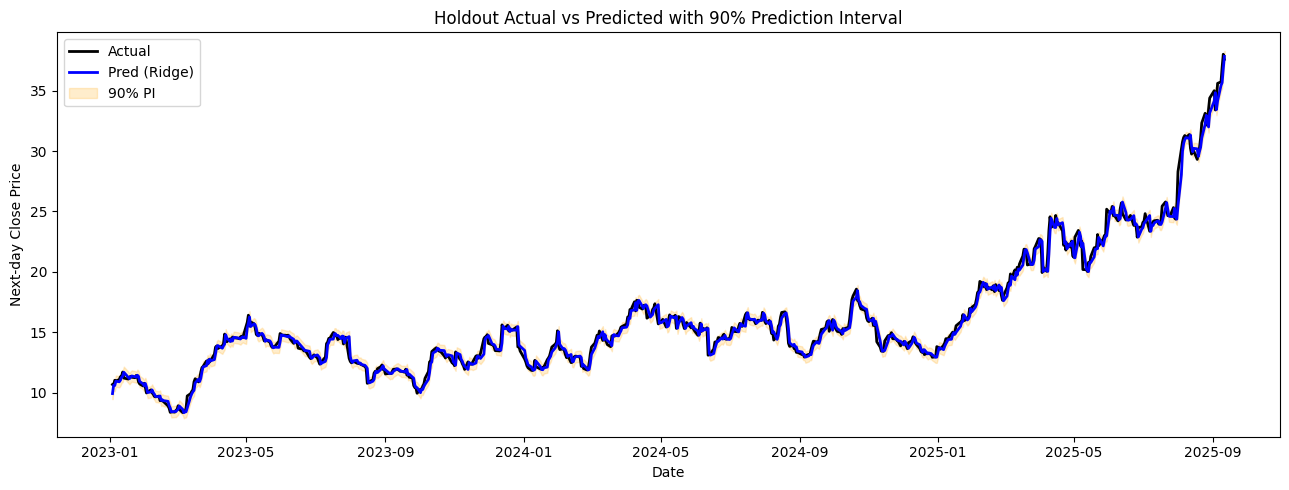

In [ ]:
# 9) Plots - Actual vs Predicted with 90% PI

# Build test dataframe for plotting
test_df = pd.DataFrame({
    "Date": pd.to_datetime(dates_test),
    "Actual": y_test,
    "Pred": y_pred,
    "Lower90": lower,
    "Upper90": upper,
}).sort_values("Date")

# Plot
plt.figure(figsize=(13, 5))
plt.plot(test_df["Date"], test_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(test_df["Date"], test_df["Pred"], label=f"Pred ({best_name})", color="blue", linewidth=2)
plt.fill_between(
    test_df["Date"], test_df["Lower90"], test_df["Upper90"],
    color="orange", alpha=0.2, label="90% PI"
)

plt.title("Holdout Actual vs Predicted with 90% Prediction Interval")
plt.xlabel("Date")
plt.ylabel("Next-day Close Price")
plt.legend()
plt.tight_layout()
plt.show()


#Residual Diagnostics

This section evaluates the residuals (errors) of the Ridge Regression model to test whether the model has captured the main structure of the data. The residuals-over-time plot shows that the errors fluctuate around zero, which is expected, though there is some higher volatility in later periods, suggesting the model struggled slightly with recent data. The ACF and PACF plots confirm that most autocorrelation values fall within the confidence bands, meaning the residuals are not strongly dependent on their past values. This indicates the model has removed most time-based patterns and left behind noise-like errors. Finally, the Q-Q plot reveals that while the residuals follow the straight line fairly well in the middle, they deviate at the tails, especially in the upper end. This means the residuals are not perfectly normally distributed and that the model sometimes produces larger-than-expected errors in extreme cases.

👉 In simple terms: the diagnostics show that the Ridge model’s errors are generally random, mostly uncorrelated, and centred around zero, which supports that the model is reliable. However, the Q-Q plot indicates heavier tails, suggesting occasional extreme prediction errors, and the later period volatility highlights moments where the model’s accuracy drops.

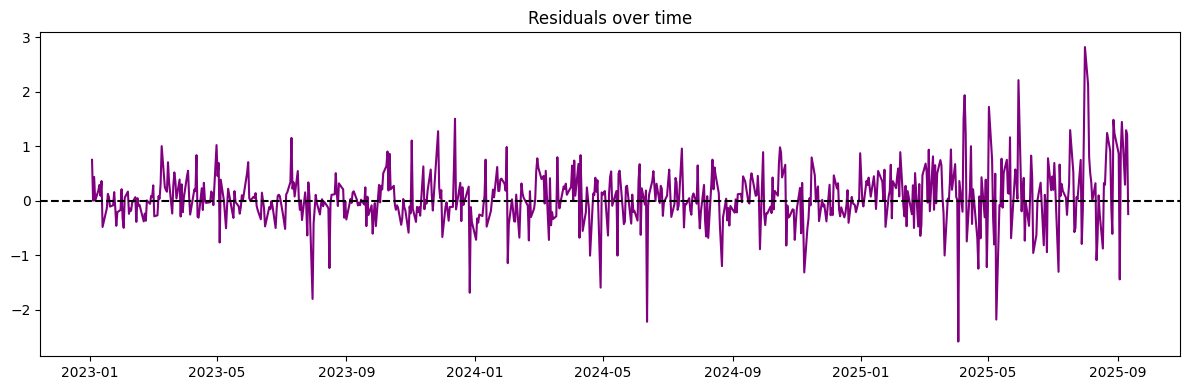

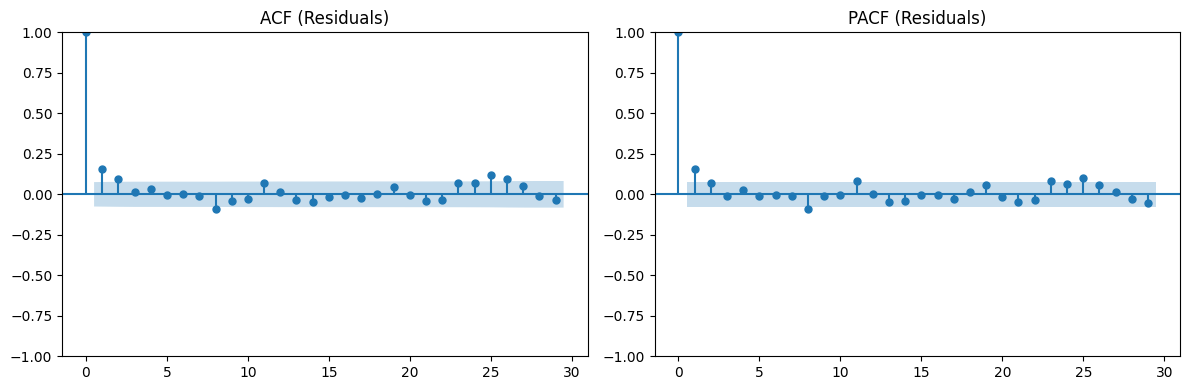

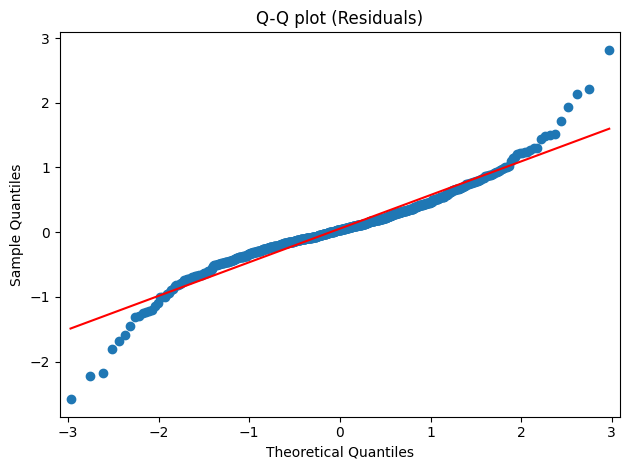

In [ ]:
# 10) Residual Diagnostics

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Compute residuals
err = test_df["Actual"].values - test_df["Pred"].values

# --- Residuals over time ---
plt.figure(figsize=(12, 4))
plt.plot(test_df["Date"], err, color="purple")
plt.axhline(0, ls="--", color="black")
plt.title("Residuals over time")
plt.tight_layout()
plt.show()

# --- ACF & PACF of residuals ---
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
plot_acf(err, ax=ax1, title="ACF (Residuals)")
ax2 = fig.add_subplot(122)
plot_pacf(err, ax=ax2, title="PACF (Residuals)", method="ywm")
plt.tight_layout()
plt.show()

# --- Q-Q plot for normality check ---
sm.qqplot(err, line="s")
plt.title("Q-Q plot (Residuals)")
plt.tight_layout()
plt.show()


#Learning Curve (XGB)

This block generates a learning curve for the XGBoost model to evaluate how its performance changes as more training data is added. Using time-series cross-validation, the model is trained on increasing portions of the dataset (from 20% up to 100%), and both the training and validation R squared values are calculated. The results are plotted with the training R squared shown in blue and the cross-validation R squared shown in red. If the training R squared is much higher than the validation R squared, it indicates overfitting. If both are low, it points to underfitting. Ideally, the two lines should converge at a relatively high R squared value, which would mean the model generalises well to unseen data.

👉 In simple terms: this section checks whether XGBoost improves as more data is added, and whether the training and validation R squared values suggest the model is learning effectively without overfitting or underfitting.

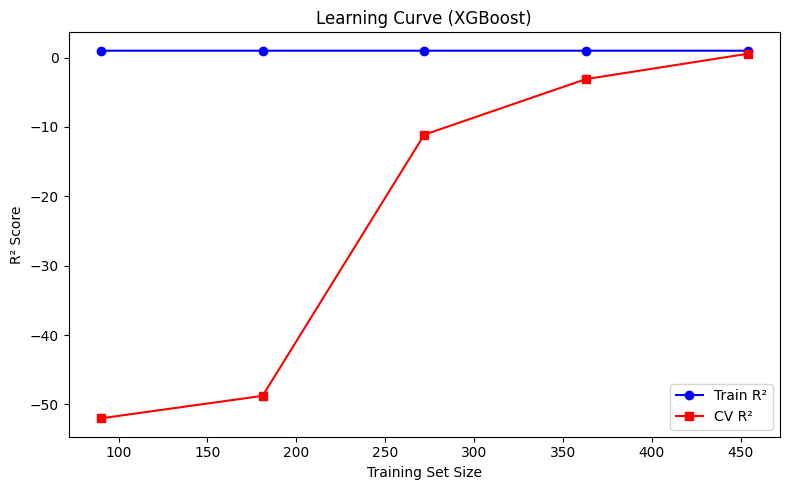

In [ ]:
# 11) Learning Curve (XGBoost)

from sklearn.model_selection import learning_curve, TimeSeriesSplit

# Compute learning curve with time-series CV
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_best,
    X=X_train,
    y=y_train,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="r2",
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1,
    shuffle=False
)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train R²", color="blue")
plt.plot(train_sizes, test_scores.mean(axis=1), marker="s", label="CV R²", color="red")

plt.title("Learning Curve (XGBoost)")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.tight_layout()
plt.show()


# Permutation Importance

This block measures permutation importance to understand which features contributed most to the Ridge model’s predictions. Permutation importance works by shuffling the values of each feature and measuring how much the model’s performance drops — the bigger the drop, the more important that feature is. The results are stored in a DataFrame and then displayed in both a table and a bar chart of the top 20 features.

From the outputs, the most important feature is clearly the “Close” price of GFI, with an importance score far higher than all others. Some moving averages (such as the 10-day and 5-day rolling means) and lag features (like Lag1 and Lag5) also contribute but to a much smaller degree. Other technical indicators, such as RSI, MACD, and rolling standard deviations, show near-zero importance, meaning they did not add much predictive power in this case.

👉 In simple terms: this analysis shows that the model mainly relied on the previous closing prices and short-term moving averages to make predictions, while more complex technical indicators played almost no role in improving accuracy.

,feature,importance
0,"('Close', 'GFI')",1.700512e+00
1,"('RollMean_10', '')",5.634819e-02
2,"('RollMean_5', '')",2.810911e-02
3,"('Lag1', '')",2.251042e-02
4,"('RollMean_20', '')",6.029099e-03
5,"('Lag5', '')",6.766975e-04
6,"('Lag10', '')",2.011597e-04
7,"('Year', '')",1.064301e-04
8,"('Return', '')",5.320311e-05
9,"('RollStd_20', '')",3.679991e-05


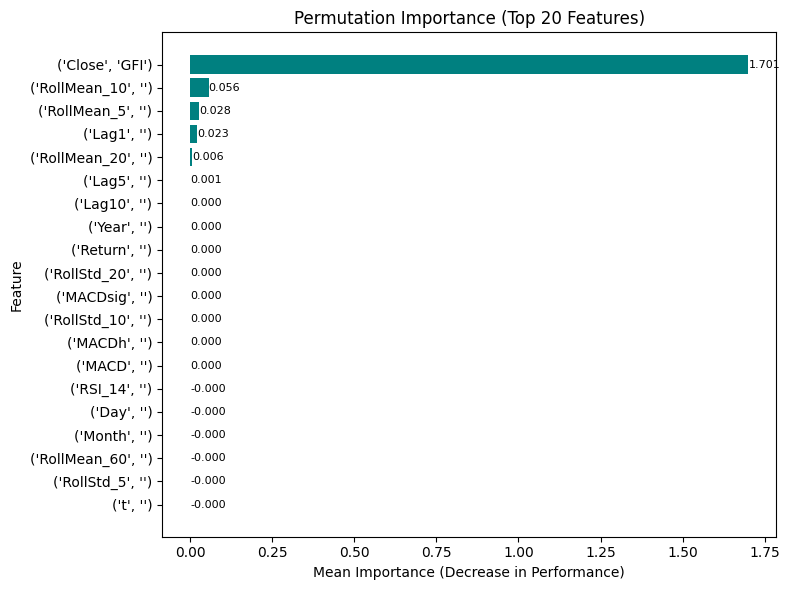

In [ ]:
# 12) Permutation Importance (Final Fixed)

from sklearn.inspection import permutation_importance

# Compute permutation importance
perm = permutation_importance(
    estimator=best_mdl,
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Build importance DataFrame
imp = (
    pd.DataFrame({
        "feature": feat_cols,
        "importance": perm.importances_mean
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Ensure correct dtypes (avoid tuple/object issues)
imp["feature"] = imp["feature"].astype(str)
imp["importance"] = imp["importance"].astype(float)

# Show top 15 in a table
display(imp.head(15))

# --- Plot Top 20 Features ---
top_imp = imp.head(20).iloc[::-1]  # reverse for barh (top at top)

plt.figure(figsize=(8, 6))
plt.barh(top_imp["feature"], top_imp["importance"], color="teal")
plt.title("Permutation Importance (Top 20 Features)")
plt.xlabel("Mean Importance (Decrease in Performance)")
plt.ylabel("Feature")

# Add value labels
for i, v in enumerate(top_imp["importance"]):
    plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=8)

plt.tight_layout()
plt.show()


# Rolling-Origin Backtest


This block performs a rolling-origin backtest (also called walk-forward validation), which is a more realistic way of testing time-series models. Instead of using one fixed training and test split, the data is repeatedly split into multiple train–test folds, where each fold moves forward in time. For each split, the model is retrained on past data and then tested on unseen future data, mimicking real-world forecasting.

The results show that all three models — Ridge, Random Forest, and XGBoost — were backtested and their performance metrics averaged across the folds. From the summary table, Ridge Regression performed best with the lowest RMSE (0.296) and MAE (0.211), along with the highest R² (0.964), meaning it explained around 96% of the variance in test data. Random Forest and XGBoost performed much worse, with significantly higher errors and lower R² values, suggesting they were less suitable for this dataset.

👉 In simple terms: this backtest confirms that Ridge Regression is the most reliable model, consistently outperforming Random Forest and XGBoost in predictive accuracy for this stock price forecasting task.

In [ ]:
# 13) Rolling Backtest (Fixed)

from sklearn.model_selection import TimeSeriesSplit

def rolling_backtest(model, X, y, splits=5):
    """Perform rolling (walk-forward) backtest with TimeSeriesSplit."""
    tscv = TimeSeriesSplit(n_splits=splits)
    rows = []

    for i, (tr, te) in enumerate(tscv.split(X)):
        mdl = model
        # Use .iloc[] to avoid index alignment issues
        mdl.fit(X.iloc[tr], y.iloc[tr])
        pred = mdl.predict(X.iloc[te])

        met = metrics_dict(y.iloc[te], pred)
        met["Fold"] = i + 1
        rows.append(met)

    return pd.DataFrame(rows)

# Run backtests for each model
bt_xgb = rolling_backtest(xgb_best, X, pd.Series(y), splits=5).assign(Model="XGBoost")
bt_rf  = rolling_backtest(rf_best,  X, pd.Series(y), splits=5).assign(Model="RandomForest")
bt_rg  = rolling_backtest(ridge_best, X, pd.Series(y), splits=5).assign(Model="Ridge")

# Combine results
bt = pd.concat([bt_rg, bt_rf, bt_xgb], ignore_index=True)

# Group by model and compute mean metrics
backtest_summary = (
    bt.groupby("Model")[["RMSE", "MAE", "MAPE%", "sMAPE%", "R2"]]
    .mean()
    .sort_values("RMSE")
)

display(backtest_summary)


,RMSE,MAE,MAPE%,sMAPE%,R2
Model,,,,,
Ridge,0.295563,0.211497,3.176996,3.226057,0.964935
RandomForest,1.546117,0.840732,6.719041,7.274729,0.683657
XGBoost,1.643666,0.938067,7.702521,8.313310,0.637469
